# Root Cause Analysis for Autonomous Optical Networks: A Physical Layer Security Use Case

Authors: Carlos Natalino, Andrea Di Giglio, Marco Schiano and Marija Furdek

Work presented at the 2020 ECOC.

This file contains the implementation of the evaluation of the unsupervised (DBSCAN) learning strategies considered in the paper, and the implementation of the root cause analysis framework proposed.
<p style='color: red'>Note that the dataset is not made available due to confidentiality agreements in place.</p>

For the unsupervised learning strategy (DBSCAN - [see documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)) we evaluate the impact of the following configuration parameters to the accuracy:
- $\epsilon$: The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster.
- $MinPts$: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import DBSCAN
from sklearn.metrics import f1_score
import pandas as pd
import os
import pickle

import matplotlib.pyplot as plt
import matplotlib as mpl

from IPython import display

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

base_alpha = .4
alpha_diff = .6

mpl.rcParams['font.size'] = 22
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['lines.markersize'] = 8

figure_format = 'svg'

## Importing dataset

Loading the dataset from the XLSX file, creating some columns and cleaning it using pandas.

<p style='color: red'>Note that the dataset is not made available due to confidentiality agreements in place.</p>

In [2]:
seed = 42
np.random.seed(seed)
folder = '...'
final_dataframe = None
file_names = ['BSL', 'INBMOD', 'INBSTRONG', 'OOBMOD', 'OOBSTRONG', 'POLMODbis', 'POLSTRONG']
class_names = ['BSL', 'INBLGT', 'INBSTR', 'OOBLGT', 'OOBSTR', 'POLLGT', 'POLSTR']
for path_e in [1, 2]:
    for idc, clazz in enumerate(file_names):
        print(path_e, clazz)
        dataframe = pd.read_excel(folder + "/" + clazz + '13' + str(path_e) + '.xlsx', 'risultati', header=[0])
        dataframe = dataframe.drop(['n', 'time stamp', 'BE-FEC', 'UBE-FEC', 'OFT', 'OFT-max', 'OFT-min'], axis=1) # removing unused features
        dataframe['path_1'] = 1 if path_e == 1 else 0
        dataframe['path_2'] = 1 if path_e == 2 else 0
        dataframe['attack'] = idc

        dataframe = dataframe[~dataframe.isin([np.nan, np.inf, -np.inf]).any(1)] # remove samples with missing data
        if final_dataframe is None:
            final_dataframe = dataframe
        else:
            final_dataframe = pd.concat([final_dataframe, dataframe], ignore_index=True)

1 BSL
1 INBMOD
1 INBSTRONG
1 OOBMOD
1 OOBSTRONG
1 POLMODbis
1 POLSTRONG
2 BSL
2 INBMOD
2 INBSTRONG
2 OOBMOD
2 OOBSTRONG
2 POLMODbis
2 POLSTRONG


In [3]:
# scaling the dataset
# class_columns = ['attack']
class_columns = ['path_1', 'path_2', 'attack']
scaler = preprocessing.StandardScaler().fit(final_dataframe.drop(class_columns, axis=1))
x_scaled = scaler.transform(final_dataframe.drop(class_columns, axis=1))
scaled_final_dataframe = pd.DataFrame(x_scaled, index=final_dataframe.index, columns=[x for x in final_dataframe.columns if x not in class_columns])
scaled_final_dataframe[class_columns] = final_dataframe[class_columns]
scaled_final_dataframe.describe()

,BER-FEC,BER-FEC-max,BER-FEC-min,BER-POST-FEC,BER-POST-FEC-max,BER-POST-FEC-min,LOSS,OPR,OPR-max,OPR-min,...,OSNR-min,PDL,PDL-max,PDL-min,Q-factor,Q-factor-max,Q-factor-min,path_1,path_2,attack
count,19882.000000,1.988200e+04,1.988200e+04,1.988200e+04,19882.000000,1.988200e+04,19882.0,1.988200e+04,1.988200e+04,1.988200e+04,...,1.988200e+04,1.988200e+04,1.988200e+04,1.988200e+04,1.988200e+04,1.988200e+04,1.988200e+04,19882.000000,19882.000000,19882.000000
mean,0.000000,-5.718079e-18,-9.148926e-17,9.148926e-17,0.000000,-9.148926e-17,0.0,2.676061e-15,-1.074999e-15,-3.339358e-15,...,3.316486e-16,2.287231e-16,-1.143616e-17,-3.202124e-16,1.944147e-16,1.143616e-17,-4.174197e-16,0.500151,0.499849,3.001257
std,1.000025,1.000025e+00,1.000025e+00,1.000025e+00,1.000025,1.000025e+00,0.0,1.000025e+00,1.000025e+00,1.000025e+00,...,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,1.000025e+00,0.500013,0.500013,2.003003
min,-0.344471,-2.069467e-01,-9.705510e-01,-4.548901e-01,-0.516286,-3.560826e-01,0.0,-1.609655e+00,-1.561280e+00,-1.630550e+00,...,-5.880710e+00,-8.858718e-01,-8.968151e-01,-9.051705e-01,-9.069171e+00,-1.000658e+01,-5.333516e+00,0.000000,0.000000,0.000000
25%,-0.211414,-1.382875e-01,-6.465515e-01,-4.548901e-01,-0.516286,-3.560826e-01,0.0,-5.622683e-01,-5.417011e-01,-5.546669e-01,...,-8.419002e-02,-8.858718e-01,-8.968151e-01,-9.051705e-01,-5.635532e-01,-6.213849e-01,-2.284833e-01,0.000000,0.000000,1.000000
50%,0.009936,-5.750807e-02,1.638493e-01,-4.548901e-01,-0.516286,-3.560826e-01,0.0,-2.225751e-01,-2.301629e-01,-2.149143e-01,...,-3.485829e-03,5.699806e-01,6.336141e-02,-9.051705e-01,-3.096542e-01,-3.453496e-01,3.563608e-03,1.000000,0.000000,3.000000
75%,0.075646,-2.940196e-02,3.659305e-01,-2.473157e-01,-0.320339,-3.041830e-01,0.0,1.171180e-01,1.096969e-01,1.248382e-01,...,5.335342e-01,5.699806e-01,6.336141e-02,1.050769e+00,8.328915e-01,1.034827e+00,5.450064e-01,1.000000,1.000000,5.000000
max,35.834467,1.454732e+01,1.163672e+02,4.062126e+00,2.605030,6.867988e+00,0.0,3.032817e+00,3.055149e+00,3.069360e+00,...,8.831717e-01,1.076095e+01,6.784597e+00,8.874528e+00,2.102387e+00,2.138968e+00,1.318496e+00,1.000000,1.000000,6.000000


In [10]:
max_values = scaled_final_dataframe.max() - scaled_final_dataframe[(scaled_final_dataframe['attack'] == 0)].max()

opm_parameters_of_interest = []
opm_parameters_of_interest_labels = []
for p in scaled_final_dataframe.columns:
     if 'max' not in p and 'min' not in p and 'attack' not in p and 'path' not in p and 'OPT' not in p and 'OFR' not in p:
            opm_parameters_of_interest.append(p)
            opm_parameters_of_interest_labels.append(p)

opm_parameters_of_interest_labels[1] = 'BER-PF'
opm_parameters_of_interest_labels[2] = 'LOS'

number_samples_attack = []
for ida, attack in enumerate(class_names):
    number_samples_attack.append(final_dataframe[(final_dataframe['attack'] == ida)].shape[0])

## Helper functions

In [5]:
# sort the DBSCAN results dictionary by the performance
def get_sorted_pairs_dbscan(performance):
    values = sorted([[performance[min_samples][epsilon]['false_positive_rate'], performance[min_samples][epsilon]['false_negative_rate']] for min_samples in performance for epsilon in performance[min_samples]], key=lambda x: x[0])
    return values

# gets the Pareto frontier of the performance
def get_curve(sorted_pairs):
    curve_fpr = []
    curve_fnr = []

    last_x = sorted_pairs[0][0]
    last_y = sorted_pairs[0][1]

    curve_fpr.append(sorted_pairs[0][0])
    curve_fnr.append(sorted_pairs[0][1])
    
    for x, y in sorted_pairs:
        if x > curve_fpr[-1] and y < curve_fnr[-1]:
            curve_fpr.append(x)
            curve_fnr.append(y)
    return curve_fpr, curve_fnr

## Unsupervised learning algorithm (DBSCAN)

In [6]:
num_tests = 50 # number of tests to be performed and obtain average accuracy
samples_normal = 100
samples_abnormal = 15

epsilon_configurations = [.1, .5, 1., 1.5, 2., 3., 4., 5., 10.]
min_samples_configurations = [3, 5, 8, 10, 12, 15, 20]

In [7]:
performance_dbscan = {}
highest_f1 = 0.

# generating the dictionary
for idm, min_samples in enumerate(min_samples_configurations):
    performance_dbscan[min_samples] = {}
    for ide, epsilon in enumerate(epsilon_configurations):
        performance_dbscan[min_samples][epsilon] = {}

print('MinPts\tepsilon\t\tfpr\tfnr\tf1')
for idm, min_samples in enumerate(min_samples_configurations):
    
    for ide, epsilon in enumerate(epsilon_configurations):

        clf = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')
        
        true_positives = []
        false_negatives = []
        true_negatives = []
        false_positives = []
        precisions = []
        recalls = []
        f1_scores = []
        num_centroids = 0
        
        for test in range(num_tests):
            start_index = np.random.randint(number_samples_attack[0]-samples_normal)
            p = scaled_final_dataframe[(scaled_final_dataframe['attack'] == 0)]
            x_data = p.values[start_index:start_index+samples_normal, :-1]
            y_data = p.values[start_index:start_index+samples_normal, -1]

            # start copy
            for i in range(num_tests):
                x_data_test = np.copy(x_data)
                y_data_test = np.copy(y_data)
                for clazz in range(1, len(class_names)):
                    start_index = np.random.randint(number_samples_attack[clazz]-samples_abnormal)
                    x = scaled_final_dataframe[(scaled_final_dataframe['attack'] == clazz)]
                    x_data_test = np.concatenate((x_data_test, x.values[start_index:start_index+samples_abnormal, :-1]), axis=0)
                    y_data_test = np.concatenate((y_data_test, x.values[start_index:start_index+samples_abnormal, -1]), axis=0)

                y_pred = clf.fit_predict(x_data_test)
                
                num_centroids += len(clf.core_sample_indices_)

                tpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])
                fnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] > 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] > 0])

                tnr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] >= 0 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])
                fpr = np.sum([1 for i in range(len(y_pred)) if y_pred[i] == -1 and y_data_test[i] == 0]) / np.sum([1 for i in range(len(y_pred)) if y_data_test[i] == 0])

                if tpr == 0: # avoids division by zero
                    precision = 0.
                    recall = 0.
                    f1 = 0.
                else:
                    precision = tpr / (tpr + fpr)
                    recall = tpr / (tpr + fnr)
                    f1 = 2 * precision * recall / (precision + recall)
                
                true_positives.append(tpr)
                false_negatives.append(fnr)
                true_negatives.append(tnr)
                false_positives.append(fpr)
                precisions.append(precision)
                recalls.append(recall)
                f1_scores.append(f1)
        
        performance_dbscan[min_samples][epsilon]['min_samples'] = min_samples
        performance_dbscan[min_samples][epsilon]['epsilon'] = epsilon
        performance_dbscan[min_samples][epsilon]['true_positive_rate'] = np.mean(true_positives)
        performance_dbscan[min_samples][epsilon]['false_negative_rate'] = np.mean(false_negatives)
        performance_dbscan[min_samples][epsilon]['true_negative_rate'] = np.mean(true_negatives)
        performance_dbscan[min_samples][epsilon]['false_positive_rate'] = np.mean(false_positives)
        performance_dbscan[min_samples][epsilon]['precision'] = np.mean(precisions)
        performance_dbscan[min_samples][epsilon]['recall'] = np.mean(recalls)
        performance_dbscan[min_samples][epsilon]['f1_score'] = np.mean(f1_scores)
        msg = ''
        if performance_dbscan[min_samples][epsilon]['f1_score'] > highest_f1:
            msg = '\t * highest'
            highest_f1 = performance_dbscan[min_samples][epsilon]['f1_score']
        print(f'{min_samples:>6}\t', f'{epsilon:>6}', '\t{:.3f}\t{:.3f}\t{:.3f}\t'.format(performance_dbscan[min_samples][epsilon]['false_positive_rate'],
                performance_dbscan[min_samples][epsilon]['false_negative_rate'],
                performance_dbscan[min_samples][epsilon]['f1_score']), msg)

print('done')

MinPts	epsilon		fpr	fnr	f1
     3	    0.1 	1.000	0.000	0.667	 	 * highest
     3	    0.5 	0.550	0.045	0.765	 	 * highest
     3	    1.0 	0.094	0.395	0.709	 
     3	    1.5 	0.011	0.697	0.455	 
     3	    2.0 	0.001	0.841	0.267	 
     3	    3.0 	0.000	0.948	0.096	 
     3	    4.0 	0.000	0.973	0.051	 
     3	    5.0 	0.000	0.983	0.032	 
     3	   10.0 	0.000	0.994	0.011	 
     5	    0.1 	1.000	0.000	0.667	 
     5	    0.5 	0.768	0.003	0.723	 
     5	    1.0 	0.146	0.221	0.807	 	 * highest
     5	    1.5 	0.013	0.627	0.531	 
     5	    2.0 	0.000	0.795	0.332	 
     5	    3.0 	0.000	0.922	0.138	 
     5	    4.0 	0.000	0.960	0.074	 
     5	    5.0 	0.000	0.974	0.050	 
     5	   10.0 	0.000	0.994	0.013	 
     8	    0.1 	1.000	0.000	0.667	 
     8	    0.5 	0.891	0.000	0.693	 
     8	    1.0 	0.203	0.084	0.864	 	 * highest
     8	    1.5 	0.018	0.498	0.651	 
     8	    2.0 	0.000	0.745	0.398	 
     8	    3.0 	0.000	0.881	0.204	 
     8	    4.0 	0.000	0.935	0.115	 
     8	    5.0 	0.000	0.961	0

## Using the best DBSCAN configuration for the RCA

In [15]:
min_samples = 12
epsilon = 1.

delta = 20
tau = 9

clf = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean')

results_diff = {}

for ida, attack in enumerate(class_names):
    
    test = 0
    
    if ida == 0:
        continue
    
    # array to store the sum (excluding the attack column)
    diff_tests = np.zeros((scaled_final_dataframe.shape[1]-1,))

    while test < num_tests:

        start_index = np.random.randint(number_samples_attack[0]-samples_normal)

        p = scaled_final_dataframe[(scaled_final_dataframe['attack'] == 0)]
        x_data = p.values[start_index:start_index+samples_normal, :-1]
        y_data = p.values[start_index:start_index+samples_normal, -1]
        
        x_data_test = np.copy(x_data)
        y_data_test = np.copy(y_data)
        
        start_index = np.random.randint(number_samples_attack[ida]-samples_abnormal)
        
        p = scaled_final_dataframe[(scaled_final_dataframe['attack'] == ida)]
        x_data_test = np.concatenate((x_data_test, p.values[start_index:start_index+samples_abnormal, :-1]), axis=0)
        y_data_test = np.concatenate((y_data_test, p.values[start_index:start_index+samples_abnormal, -1]), axis=0)
        
        y_pred = clf.fit_predict(x_data_test)
        
        sum_positive = np.sum([1 for x in y_pred[-delta:] if x == -1])
        
        if sum_positive >= tau: # an attack was detected
            test += 1
            
            for idf, feature in enumerate(scaled_final_dataframe.columns[:-1]):
                sum_normal = np.sum(x_data_test[:samples_normal, idf]) / samples_normal
                sum_abnormal = np.sum(x_data_test[samples_normal:, idf]) / samples_abnormal
                if max_values[feature] != .0:
                    diff_tests[idf] += (sum_abnormal - sum_normal) / max_values[feature]
                else:
                    diff_tests[idf] += sum_abnormal - sum_normal
            
    diff_tests /= float(num_tests)

    results_diff[attack] = diff_tests

# writing the results to a file
# note that due to the random nature of these tests, every run might yield different results
# with open('models/results_rca.h5', 'wb') as f:
#     pickle.dump(results_diff, f)

## Plotting the results

In [16]:
with open('models/results_rca.h5', 'rb') as f:
    results_diff = pickle.load(f)

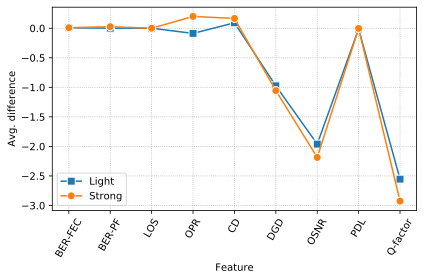

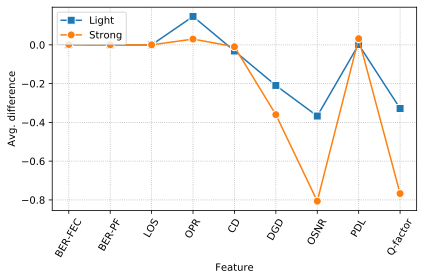

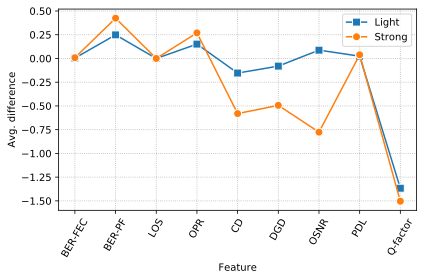

In [17]:
for attack in ['INB', 'OOB', 'POL']:
    plt.figure()
    plt.grid()
    plt.plot([results_diff[attack+'LGT'][idf] for idf, feature in enumerate(scaled_final_dataframe.columns) if feature in opm_parameters_of_interest], label='Light', marker='s', markeredgecolor='white')
    plt.plot([results_diff[attack+'STR'][idf] for idf, feature in enumerate(scaled_final_dataframe.columns) if feature in opm_parameters_of_interest], label='Strong', marker='o', markeredgecolor='white')
    
    plt.xlabel('Feature')
    plt.ylabel('Avg. difference')
    plt.xticks(range(len(opm_parameters_of_interest)), opm_parameters_of_interest_labels, rotation=60)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'./figures/{attack}.pdf')
    plt.show()

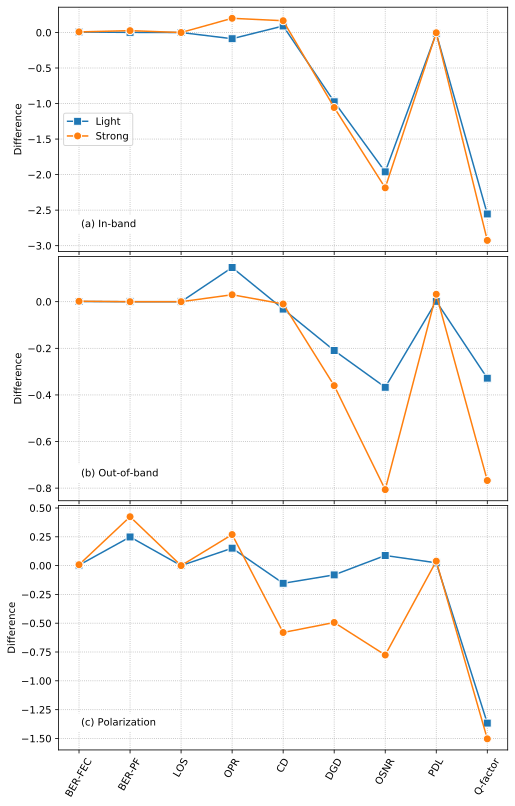

In [19]:
fig_kw=dict(figsize=(8, 12))
f, axs = plt.subplots(nrows=3, sharex=True, squeeze=True, **fig_kw)

texts = ['(a) In-band', '(b) Out-of-band', '(c) Polarization']
opm_parameters_of_interest_labels[2] = 'LOS'
for ida, attack in enumerate(['INB', 'OOB', 'POL']):

    axs[ida].plot([results_diff[attack+'LGT'][idf] for idf, feature in enumerate(scaled_final_dataframe.columns) if feature in opm_parameters_of_interest], label='Light', marker='s', markeredgecolor='white')
    axs[ida].plot([results_diff[attack+'STR'][idf] for idf, feature in enumerate(scaled_final_dataframe.columns) if feature in opm_parameters_of_interest], label='Strong', marker='o', markeredgecolor='white')
    axs[ida].set_ylabel('Difference')
    axs[ida].grid()
    x_lim = axs[ida].get_xlim()
    y_lim = axs[ida].get_ylim()
    axs[ida].text(.05, .1, texts[ida], transform=axs[ida].transAxes,
                    bbox=dict(facecolor='white', edgecolor='white', alpha=1.0))

axs[0].legend(loc=6)
plt.xticks(range(len(opm_parameters_of_interest)), opm_parameters_of_interest_labels, rotation=60)
plt.subplots_adjust(left=0.2, bottom=0.13, right=.98, top=.99, 
                    wspace=0, hspace=0.02)
plt.savefig(f'./figures/results.pdf')
plt.show()